In [1]:
import os # accessing directory structure
import random
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

import cv2
from PIL import Image
import os # accessing directory structure

from skimage import color
from skimage import io

from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import add
from sklearn.model_selection import train_test_split

from keras.utils import plot_model

from keras.layers import Dense
from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.models import Model

#---------------------------------------------------------------------------------------------#

OriginalImages = [] #path of original images 
DownsampledImages = [] 
DownsampledImagesTest = [] 
UpsampledImages = []
labels=[] #labels corresponding to images
lables_test=[]
OriginalImagesTest = []
d=[]
f=[]
y=0
j=0

#code for extracting images from the data folder
for dirname, _, filenames in os.walk('/kaggle/input/cfpw-dataset/cfp-dataset/Data/Images'):
    y+=1
    i=0
    for filename in filenames:
        i+=1
        d.append(dirname)
        x=dirname
        f.append(filename)
        if(x[-7:]=="frontal"):
            if(i<=3):
                image = os.path.join(dirname, filename)
                OriginalImages.append( os.path.join(dirname, filename))
                j+=1
                labels.append(y)
            elif(i==4):
                image = os.path.join(dirname, filename)
                OriginalImagesTest.append( os.path.join(dirname, filename))
                lables_test.append(y)
                break
        else:
            break
        
print('Total images ', len(OriginalImages))

def displayImage(imagePath):
    image = mpimg.imread(imagePath)
    plt.imshow(image)
    print('Image path', imagePath)
    print('Image size -', image.shape)
    plt.show()

Total images  1500


In [2]:
image=[] #reshaped original images
imagetest=[]

In [3]:
#extracting the image from path and then reshaping it to size 384X384X3
def reshape_image(imageIndex):
    image1 = mpimg.imread(OriginalImages[imageIndex])
    resized = cv2.resize(image1, (384, 384))
    image.append(resized.astype('uint8'))

In [4]:
def reshape_image_test(imageIndex):
    image1 = mpimg.imread(OriginalImages[imageIndex])
    resized = cv2.resize(image1, (384, 384))
    imagetest.append(resized.astype('uint8'))

In [5]:
for i in range(len(OriginalImages)):
    reshape_image(i)
for i in range(len(OriginalImagesTest)):
    reshape_image_test(i)

In [6]:
def Downsample(image1):
#     image1 = mpimg.imread(OriginalImages[imageIndex])
    m, n, o = image1.shape
#     print("Our down-sampled NumPy array has the shape: {}".format(image1.shape))
    f = 4 #bicubic dowsampling
    image2 = np.zeros([m//f , n//f , o])
    for i in range(0,m):
        for j in range(0,n):
            for k in range(0,o):
                image2[i//f, j//f, k] = image1[i, j, k]
    
    DownsampledImages.append(image2.astype('uint8'))

In [7]:
len(OriginalImages)

1500

In [8]:
#Downsampling to generate artificial dataset
for i in range(len(image)):
    Downsample(image[i])

In [9]:
len(DownsampledImages)

1500

In [10]:
type(DownsampledImages[0])

numpy.ndarray

In [11]:
DownsampledImages[0].shape

(96, 96, 3)

In [12]:
#normalizing the image from to get all pixel values from -1 to 1
def normalizeimg(img):
    temp=[]
    for i in range(len(img)):
        x=img[i]
        arr=(x-127.5)/127.5
        temp.append(x)
    return temp

In [13]:
high_res=normalizeimg(image) #final high resolution images for training

In [14]:
low_res=normalizeimg(DownsampledImages) #final low resolution images for training
#GANs are trained from high resolution images and corresponding low resolution image

In [15]:
#making residual block to be used in generator
def residualblock(model, kernal_size, filters, strides):    
    gen = model
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)#used for applying regularization effects, momentum=0.5 means 50% weightage given to previous estimations
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model) #PreRelu is used instead of Relu as it gives non zero outputs at negative inputs
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = add([gen, model]) 
    return model

In [16]:
def upsampling(model, kernal_size, filters, strides):
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    return model

In [17]:
#making class for Generator Model
class Generator_model(object):
    def __init__(self, noise_shape):
        self.noise_shape = noise_shape
        
    def generator(self):
        gen_input = Input(shape = self.noise_shape)
        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        gen_model = model

        # Adding 4 Residual Blocks
        for index in range(4):
            model = residualblock(model, 3, 64, 1)
     
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])
     
        # Using 2 UpSampling Blocks
        for index in range(2):
            model = upsampling(model, 3, 256, 1)
     
        model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)#tanh fucntion has steeper gradients which makes it fast to train
        generator_model = Model(inputs = gen_input, outputs = model)
        return generator_model

In [18]:
def discriminator_block(model, filters, kernel_size, strides):
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    return model

In [19]:
#function defining discriminator layers
def discriminator(image_shape):
    dis_input = Input(shape = image_shape) 
    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
    model = LeakyReLU(alpha = 0.2)(model)   
    model = discriminator_block(model, 64, 3, 2)
#     model = discriminator_block(model, 128, 3, 1)
    model = discriminator_block(model, 128, 3, 2)
#     model = discriminator_block(model, 256, 3, 1)
    model = discriminator_block(model, 256, 3, 2)
#     model = discriminator_block(model, 512, 3, 1)
    model = discriminator_block(model, 512, 3, 2) 
    model = Flatten()(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model) 
    discriminator_model = Model(inputs = dis_input, outputs = model)
    return discriminator_model

In [20]:
from keras.applications.vgg19 import VGG19
import keras.backend as K
from keras.models import Model

In [21]:
from keras.models import Model
from keras.layers import Input

In [22]:
#defining complete GAN model
def gan_model(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gan

In [23]:
#defining Adam optimizer with learning rate and other parameters
def get_optimizer():
    adam = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [24]:
from tqdm import tqdm
import numpy as np

In [25]:
downscale_factor = 4
# Remember to change image shape if you are having different size of images
image_shape = (384,384,3)
epochs=200
batch_size=64
import tensorflow as tf

In [26]:
def generate_real_samples(data,n_samples):
    x_rand=randint(0,len(data),n_samples) #array having index of selected images from dataset
    #selecting n_samples random index arrays from 0 to len(data)
    x_temp=[]
    for i in range(len(x_rand)):
        x_temp.append(data[x_rand[i]])
    return x_temp

In [35]:
def train(epochs, batch_size,low_res,high_res,downscale_factor,g_model,d_model,gan):

    x_train_lr,x_test_lr,x_train_hr,x_test_hr=train_test_split(low_res,high_res,test_size=0.3,random_state=42)
    batch_count = int(len(x_train_hr) / batch_size)
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    optimizer = get_optimizer()
    g_model.compile(loss="binary_crossentropy", optimizer=optimizer)
    d_model.compile(loss="binary_crossentropy", optimizer=optimizer)
#     loss_file = open(model_save_dir + 'losses.txt' , 'w+')
#     loss_file.close()
    print('Epoch number-',epochs)
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for i in range(batch_count+1):
            image_hr = generate_real_samples(x_train_hr,batch_size)
            image_hr=np.array(image_hr)
            image_lr = generate_real_samples(x_train_lr,batch_size)
            image_lr=np.array(image_lr)
            generated_images_sr = g_model.predict(image_lr)
            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2 #taking real data values from 0.2 to 0.8
            fake_data_Y = np.random.random_sample(batch_size)*0.2 #taking real data values from 0 to 0.2
            d_model.trainable = True
            dloss_real = d_model.train_on_batch(image_hr, real_data_Y)
            dloss_fake = d_model.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(dloss_fake, dloss_real)
            fake_data_Y_2 = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            d_model.trainable = False
            gan_loss = gan.train_on_batch(image_lr, [image_hr,fake_data_Y_2])
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        if e % 25 == 0:
            g_model.save('gen_model%d.h5')
            d_model.save('dis_model%d.h5')
            gan.save('gan.h5')

In [28]:
shape=(96, 96, 3)
optimizer = get_optimizer()

In [29]:
g_model = Generator_model(shape).generator()
d_model = discriminator(image_shape)
gan = gan_model(d_model, shape, g_model, optimizer)

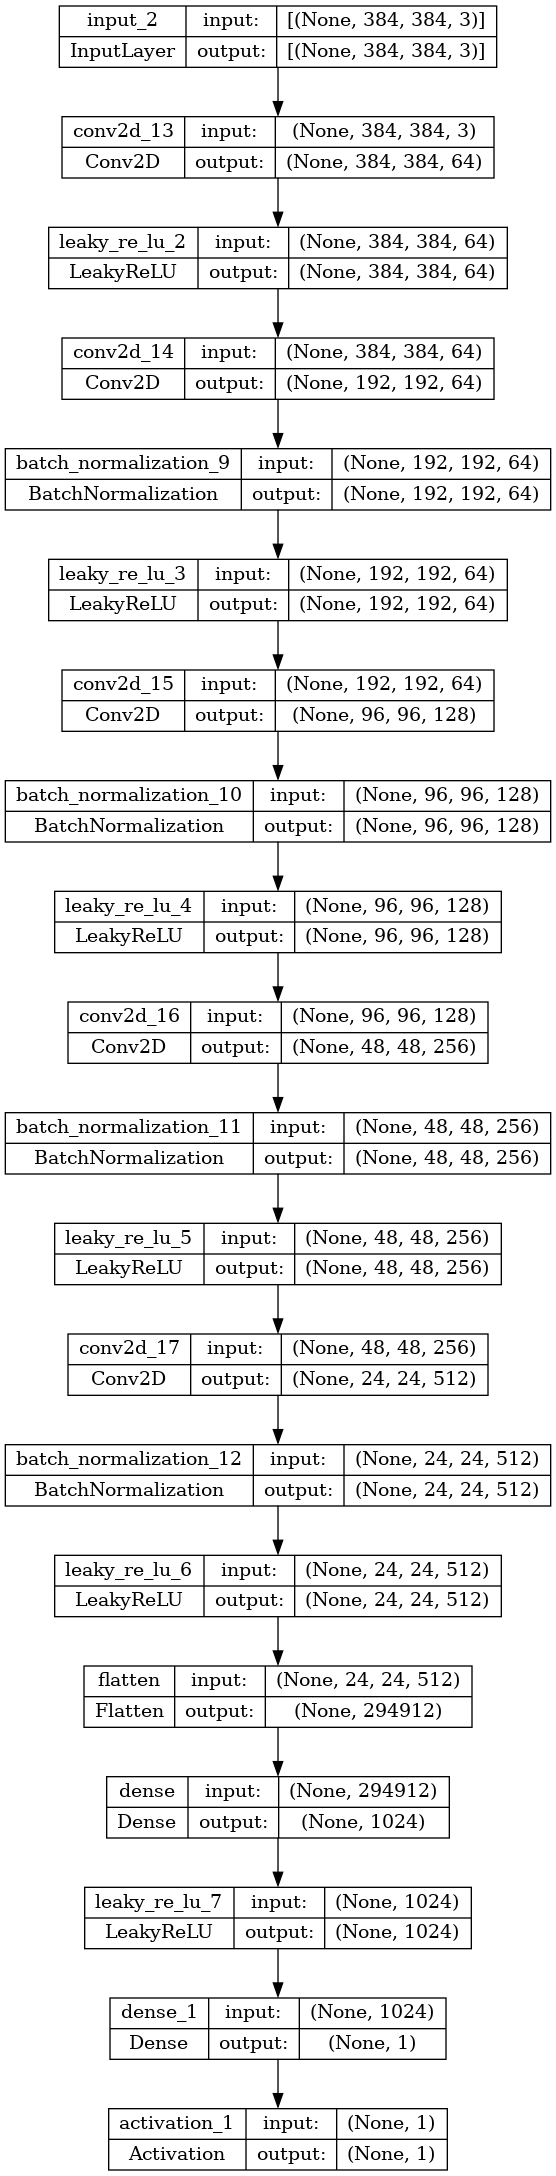

In [30]:
plot_model( d_model, to_file='Discriminator.png', show_shapes=True, show_layer_names=True, rankdir='TB')

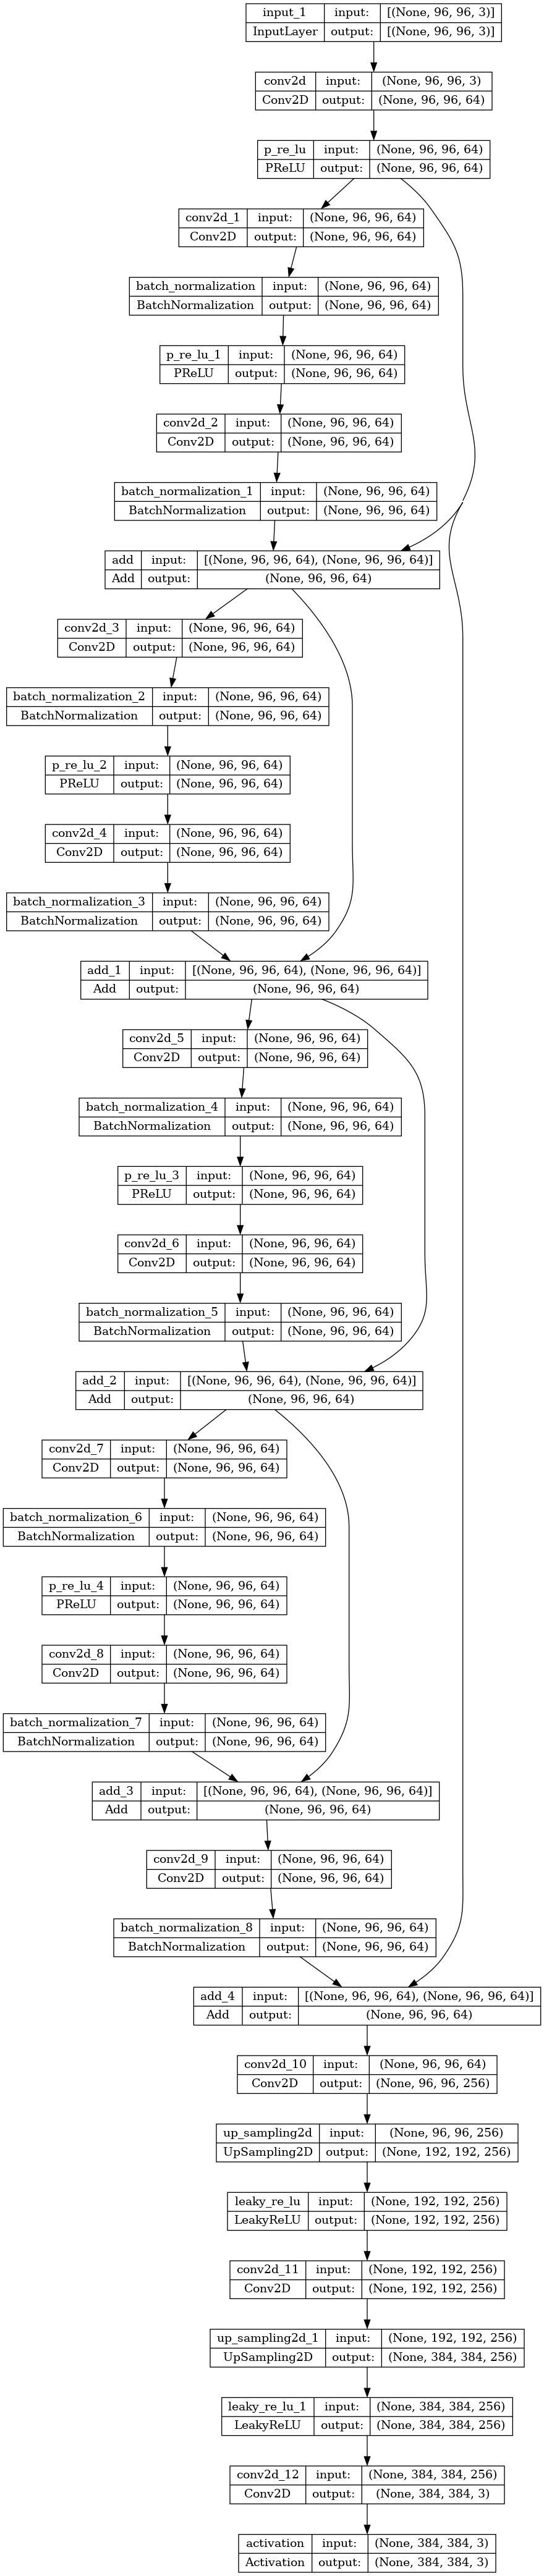

In [31]:
plot_model( g_model, to_file='Generator.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
with tf.device('/device:GPU:0'):
    train(epochs,batch_size,low_res,high_res,downscale_factor,g_model,d_model,gan)

Epoch number- 200
--------------- Epoch 1 ---------------
2/2 [==============================] - 116s 57s/step
